In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Estilo profesional
plt.rcParams['figure.facecolor'] = '#0f1117'
plt.rcParams['axes.facecolor']   = '#1a1d2e'
plt.rcParams['axes.labelcolor']  = 'white'
plt.rcParams['xtick.color']      = 'white'
plt.rcParams['ytick.color']      = 'white'
plt.rcParams['text.color']       = 'white'

# ✅ Rutas
PROJECT_ROOT = os.path.join(
    r"C:\Users\matup\OneDrive\Documentos",
    "sistema_de_Predicción_de_Fallos_en_Última Milla"
)
DATA_RAW       = os.path.join(PROJECT_ROOT, "data", "raw",
                 "dataset_distribucion_nacional2.csv")
DATA_PROCESSED = os.path.join(PROJECT_ROOT, "data", "processed",
                 "dataset_limpio.csv")
FIGURES_PATH   = os.path.join(PROJECT_ROOT, "outputnts", "figures")
REPORTS_PATH   = os.path.join(PROJECT_ROOT, "outputnts", "reports")

os.makedirs(os.path.join(PROJECT_ROOT, "data", "processed"), exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)

# ✅ Cargar datos
df = pd.read_csv(DATA_RAW)
df_original = df.copy()

print("✅ Datos cargados correctamente")
print(f"   Filas    : {len(df):,}")
print(f"   Columnas : {len(df.columns)}")
print(f"\n📋 Columnas disponibles:")
for col in df.columns:
    print(f"   → {col} ({df[col].dtype})")

✅ Datos cargados correctamente
   Filas    : 500,000
   Columnas : 23

📋 Columnas disponibles:
   → shipment_id (int64)
   → fecha_envio (str)
   → provincia (str)
   → latitud (float64)
   → longitud (float64)
   → zona (str)
   → zona_peligrosa (int64)
   → clima (str)
   → evento_especial (str)
   → tipo_cliente (str)
   → transportista (str)
   → chofer (str)
   → distancia_km (float64)
   → tiempo_estimado_horas (float64)
   → tiempo_real_horas (float64)
   → demora_horas (float64)
   → estado (str)
   → motivo_fallo (str)
   → costo_envio (float64)
   → entrega_exitosa (int64)
   → mes (int64)
   → anio (int64)
   → dia_semana (str)


🔍 DIAGNÓSTICO DE CALIDAD DE DATOS

📌 Resumen de calidad:
                          Tipo   Nulos  Porcentaje  Únicos              Ejemplo
shipment_id              int64       0         0.0  500000                    1
fecha_envio                str       0         0.0  369817  2022-01-01 07:02:00
provincia                  str       0         0.0      15              Neuquén
latitud                float64       0         0.0  485671           -38.890816
longitud               float64       0         0.0  483063           -67.342172
zona                       str       0         0.0       4       Zona Peligrosa
zona_peligrosa           int64       0         0.0       2                    1
clima                      str       0         0.0      10              Soleado
evento_especial            str       0         0.0      12            Año Nuevo
tipo_cliente               str       0         0.0       3              Empresa
transportista              str       0         0.0       5     

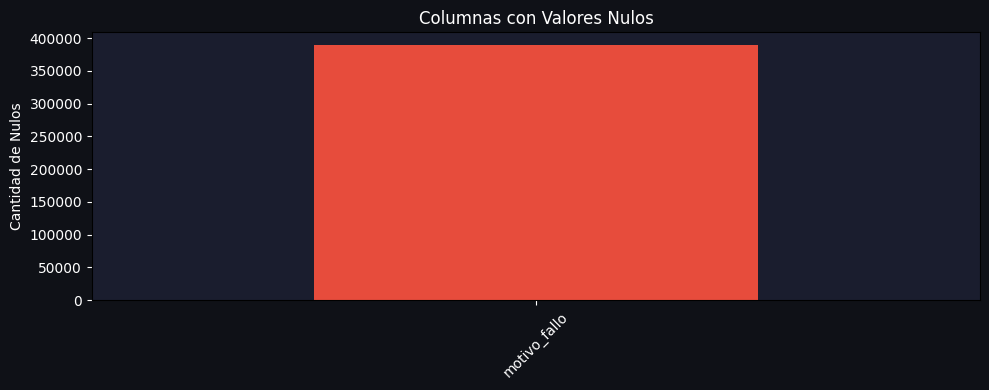

In [2]:
print("=" * 60)
print("🔍 DIAGNÓSTICO DE CALIDAD DE DATOS")
print("=" * 60)

# ── Nulos ─────────────────────────────────────────────────
nulos     = df.isnull().sum()
nulos_pct = (nulos / len(df) * 100).round(2)
resumen   = pd.DataFrame({
    'Tipo'       : df.dtypes,
    'Nulos'      : nulos,
    'Porcentaje' : nulos_pct,
    'Únicos'     : df.nunique(),
    'Ejemplo'    : df.iloc[0]
})

print("\n📌 Resumen de calidad:")
print(resumen.to_string())

print(f"\n📌 Duplicados: {df.duplicated().sum():,}")
print(f"📌 Memoria   : {df.memory_usage(deep=True).sum()/1024**2:.1f} MB")

# ── Visualizar nulos ──────────────────────────────────────
cols_con_nulos = nulos[nulos > 0]
if len(cols_con_nulos) > 0:
    fig, ax = plt.subplots(figsize=(10, 4))
    cols_con_nulos.plot(kind='bar', ax=ax, color='#e74c3c')
    ax.set_title('Columnas con Valores Nulos')
    ax.set_ylabel('Cantidad de Nulos')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, "limpieza_01_nulos.png"),
                dpi=150, bbox_inches='tight', facecolor='#0f1117')
    plt.show()
else:
    print("\n✅ No hay valores nulos en columnas numéricas principales")

In [3]:
print("=" * 60)
print("🧹 LIMPIEZA DE DATOS")
print("=" * 60)

df_limpio = df.copy()

# ── 1. Convertir fechas ───────────────────────────────────
df_limpio['fecha_envio'] = pd.to_datetime(df_limpio['fecha_envio'])
print("✅ Fechas convertidas correctamente")

# ── 2. Tratar nulos en motivo_fallo ───────────────────────
# Es normal que sea nulo cuando la entrega fue exitosa
df_limpio['motivo_fallo'] = df_limpio['motivo_fallo'].fillna('Sin Fallo')
print(f"✅ motivo_fallo: nulos rellenados con 'Sin Fallo'")

# ── 3. Eliminar duplicados si existen ────────────────────
n_antes = len(df_limpio)
df_limpio = df_limpio.drop_duplicates(subset=['shipment_id'])
n_despues = len(df_limpio)
print(f"✅ Duplicados eliminados: {n_antes - n_despues:,}")

# ── 4. Verificar rangos lógicos ───────────────────────────
# Distancia no puede ser negativa
mask_dist = df_limpio['distancia_km'] < 0
print(f"✅ Distancias negativas encontradas: {mask_dist.sum():,}")
df_limpio.loc[mask_dist, 'distancia_km'] = df_limpio['distancia_km'].abs()

# Costos no pueden ser negativos
mask_costo = df_limpio['costo_envio'] < 0
print(f"✅ Costos negativos encontrados: {mask_costo.sum():,}")
df_limpio.loc[mask_costo, 'costo_envio'] = df_limpio['costo_envio'].abs()

# Tiempo real no puede ser menor a 1 hora
mask_tiempo = df_limpio['tiempo_real_horas'] < 1
print(f"✅ Tiempos reales < 1 hora: {mask_tiempo.sum():,}")
df_limpio.loc[mask_tiempo, 'tiempo_real_horas'] = 1.0

# ── 5. Estandarizar texto en categóricas ──────────────────
cat_cols = ['transportista', 'zona', 'tipo_cliente',
            'provincia', 'clima', 'evento_especial',
            'estado', 'motivo_fallo']
for col in cat_cols:
    if col in df_limpio.columns:
        df_limpio[col] = df_limpio[col].str.strip().str.title()

print("✅ Texto estandarizado en columnas categóricas")

print(f"\n📊 Dataset después de limpieza:")
print(f"   Filas    : {len(df_limpio):,}")
print(f"   Nulos    : {df_limpio.isnull().sum().sum():,}")
print(f"   Columnas : {len(df_limpio.columns)}")

🧹 LIMPIEZA DE DATOS
✅ Fechas convertidas correctamente
✅ motivo_fallo: nulos rellenados con 'Sin Fallo'
✅ Duplicados eliminados: 0
✅ Distancias negativas encontradas: 0
✅ Costos negativos encontrados: 0
✅ Tiempos reales < 1 hora: 0
✅ Texto estandarizado en columnas categóricas

📊 Dataset después de limpieza:
   Filas    : 500,000
   Nulos    : 0
   Columnas : 23


In [4]:
print("=" * 60)
print("⚙️  FEATURE ENGINEERING")
print("=" * 60)

# ── 1. Features de tiempo ─────────────────────────────────
df_limpio['diferencia_tiempo'] = (df_limpio['tiempo_real_horas']
                                  - df_limpio['tiempo_estimado_horas'])
df_limpio['llego_tarde']       = (df_limpio['diferencia_tiempo'] > 0).astype(int)
df_limpio['eficiencia_tiempo'] = (df_limpio['tiempo_estimado_horas']
                                  / df_limpio['tiempo_real_horas'].clip(0.1))

# ── 2. Features de costo ──────────────────────────────────
df_limpio['costo_por_km']    = (df_limpio['costo_envio']
                                / df_limpio['distancia_km'].clip(1))
df_limpio['velocidad_kmh']   = (df_limpio['distancia_km']
                                / df_limpio['tiempo_real_horas'].clip(0.1))

# ── 3. Features de fecha ──────────────────────────────────
df_limpio['fecha_envio']    = pd.to_datetime(df_limpio['fecha_envio'])
df_limpio['dia_del_anio']   = df_limpio['fecha_envio'].dt.dayofyear
df_limpio['semana_del_anio'] = df_limpio['fecha_envio'].dt.isocalendar().week.astype(int)
df_limpio['es_fin_semana']  = (df_limpio['fecha_envio'].dt.dayofweek >= 5).astype(int)
df_limpio['es_quincena']    = (df_limpio['fecha_envio'].dt.day >= 15).astype(int)

# ── 4. Feature de estación ────────────────────────────────
def get_estacion(mes):
    if mes in [12, 1, 2]:  return 'Verano'
    elif mes in [3, 4, 5]: return 'Otoño'
    elif mes in [6, 7, 8]: return 'Invierno'
    else:                   return 'Primavera'

df_limpio['estacion'] = df_limpio['mes'].apply(get_estacion)

# ── 5. Feature de riesgo compuesto ────────────────────────
# Score de riesgo basado en zona, clima y evento
riesgo_zona = {
    'Zona Peligrosa': 4, 'Rural': 3,
    'Suburbana': 2,      'Urbana': 1
}
riesgo_clima = {
    'Tormentoso': 4, 'Nieve': 4, 'Neblina': 3,
    'Lluvioso': 3,   'Ventoso': 2, 'Lluvia Leve': 2,
    'Nublado': 1,    'Frío': 1, 'Caluroso': 1, 'Soleado': 0
}
riesgo_evento = {
    'Navidad': 3,     'Cyber Monday': 3, 'Hot Sale': 3,
    'Aguinaldo': 2,   'Día De La Madre': 2,
    'Día Del Padre': 2, 'Día Del Niño': 2,
    'San Valentín': 1, 'Vuelta Al Cole': 1,
    'Vacaciones Invierno': 1, 'Año Nuevo': 2, 'Normal': 0
}

df_limpio['score_riesgo'] = (
    df_limpio['zona'].map(riesgo_zona).fillna(1) +
    df_limpio['clima'].map(riesgo_clima).fillna(0) +
    df_limpio['evento_especial'].map(riesgo_evento).fillna(0)
)

print("✅ Features nuevos creados:")
nuevos_features = ['diferencia_tiempo', 'llego_tarde', 'eficiencia_tiempo',
                   'costo_por_km', 'velocidad_kmh', 'dia_del_anio',
                   'semana_del_anio', 'es_fin_semana', 'es_quincena',
                   'estacion', 'score_riesgo']
for f in nuevos_features:
    print(f"   → {f}")

print(f"\n📊 Total columnas ahora: {len(df_limpio.columns)}")

⚙️  FEATURE ENGINEERING
✅ Features nuevos creados:
   → diferencia_tiempo
   → llego_tarde
   → eficiencia_tiempo
   → costo_por_km
   → velocidad_kmh
   → dia_del_anio
   → semana_del_anio
   → es_fin_semana
   → es_quincena
   → estacion
   → score_riesgo

📊 Total columnas ahora: 34


In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

print("=" * 60)
print("🔢 ENCODING DE VARIABLES CATEGÓRICAS")
print("=" * 60)

df_encoded = df_limpio.copy()

# ── Label Encoding para variables ordinales ───────────────
le = LabelEncoder()
label_cols = ['provincia', 'zona', 'tipo_cliente', 'transportista',
              'clima', 'evento_especial', 'estacion',
              'motivo_fallo', 'dia_semana']

encoders = {}
for col in label_cols:
    if col in df_encoded.columns:
        encoders[col] = LabelEncoder()
        df_encoded[f'{col}_encoded'] = encoders[col].fit_transform(
            df_encoded[col].astype(str))
        print(f"✅ {col} → {col}_encoded "
              f"({df_encoded[col].nunique()} categorías)")

# ── Encoding del target multiclase ───────────────────────
encoders['estado'] = LabelEncoder()
df_encoded['estado_encoded'] = encoders['estado'].fit_transform(
    df_encoded['estado'].astype(str))

print(f"\n📌 Mapeo de estados:")
for i, clase in enumerate(encoders['estado'].classes_):
    print(f"   {i} → {clase}")

# ── One Hot Encoding para zona (importante para ML) ───────
dummies_zona = pd.get_dummies(df_encoded['zona'],
                               prefix='zona', drop_first=False)
df_encoded = pd.concat([df_encoded, dummies_zona], axis=1)
print(f"\n✅ One-Hot Encoding zona: {list(dummies_zona.columns)}")

print(f"\n📊 Total columnas después del encoding: {len(df_encoded.columns)}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS
✅ provincia → provincia_encoded (15 categorías)
✅ zona → zona_encoded (4 categorías)
✅ tipo_cliente → tipo_cliente_encoded (3 categorías)
✅ transportista → transportista_encoded (5 categorías)
✅ clima → clima_encoded (10 categorías)
✅ evento_especial → evento_especial_encoded (12 categorías)
✅ estacion → estacion_encoded (4 categorías)
✅ motivo_fallo → motivo_fallo_encoded (14 categorías)
✅ dia_semana → dia_semana_encoded (7 categorías)

📌 Mapeo de estados:
   0 → Demorado
   1 → Devuelto
   2 → Entregado
   3 → Perdido

✅ One-Hot Encoding zona: ['zona_Rural', 'zona_Suburbana', 'zona_Urbana', 'zona_Zona Peligrosa']

📊 Total columnas después del encoding: 48


In [6]:
print("=" * 60)
print("📏 ESCALADO DE VARIABLES NUMÉRICAS")
print("=" * 60)

# ── Columnas a escalar ────────────────────────────────────
cols_escalar = ['distancia_km', 'costo_envio', 'tiempo_estimado_horas',
                'tiempo_real_horas', 'demora_horas', 'costo_por_km',
                'velocidad_kmh', 'score_riesgo', 'eficiencia_tiempo']

cols_escalar = [c for c in cols_escalar if c in df_encoded.columns]

scaler     = StandardScaler()
df_scaled  = df_encoded.copy()

# ⚠️ El scaler se aplica DESPUÉS del split en el notebook de modelado
# Acá solo guardamos las columnas que se van a escalar
print("📌 Columnas que se escalarán en el modelado:")
for col in cols_escalar:
    media  = df_encoded[col].mean()
    desvio = df_encoded[col].std()
    print(f"   → {col:30} media={media:10.2f} | std={desvio:10.2f}")

import joblib
os.makedirs(os.path.join(PROJECT_ROOT, "outputnts", "models"), exist_ok=True)
joblib.dump(cols_escalar,
            os.path.join(PROJECT_ROOT, "outputnts", "models", "cols_escalar.pkl"))
joblib.dump(encoders,
            os.path.join(PROJECT_ROOT, "outputnts", "models", "encoders.pkl"))

print("\n✅ Configuración guardada:")
print("   → outputnts/models/cols_escalar.pkl")
print("   → outputnts/models/encoders.pkl")

📏 ESCALADO DE VARIABLES NUMÉRICAS
📌 Columnas que se escalarán en el modelado:
   → distancia_km                   media=    195.23 | std=    147.94
   → costo_envio                    media=   7231.87 | std=   6612.10
   → tiempo_estimado_horas          media=     29.09 | std=     10.13
   → tiempo_real_horas              media=     30.47 | std=     10.78
   → demora_horas                   media=      1.38 | std=      2.62
   → costo_por_km                   media=     46.52 | std=     40.92
   → velocidad_kmh                  media=      6.63 | std=      4.78
   → score_riesgo                   media=      4.43 | std=      2.07
   → eficiencia_tiempo              media=      0.96 | std=      0.07

✅ Configuración guardada:
   → outputnts/models/cols_escalar.pkl
   → outputnts/models/encoders.pkl


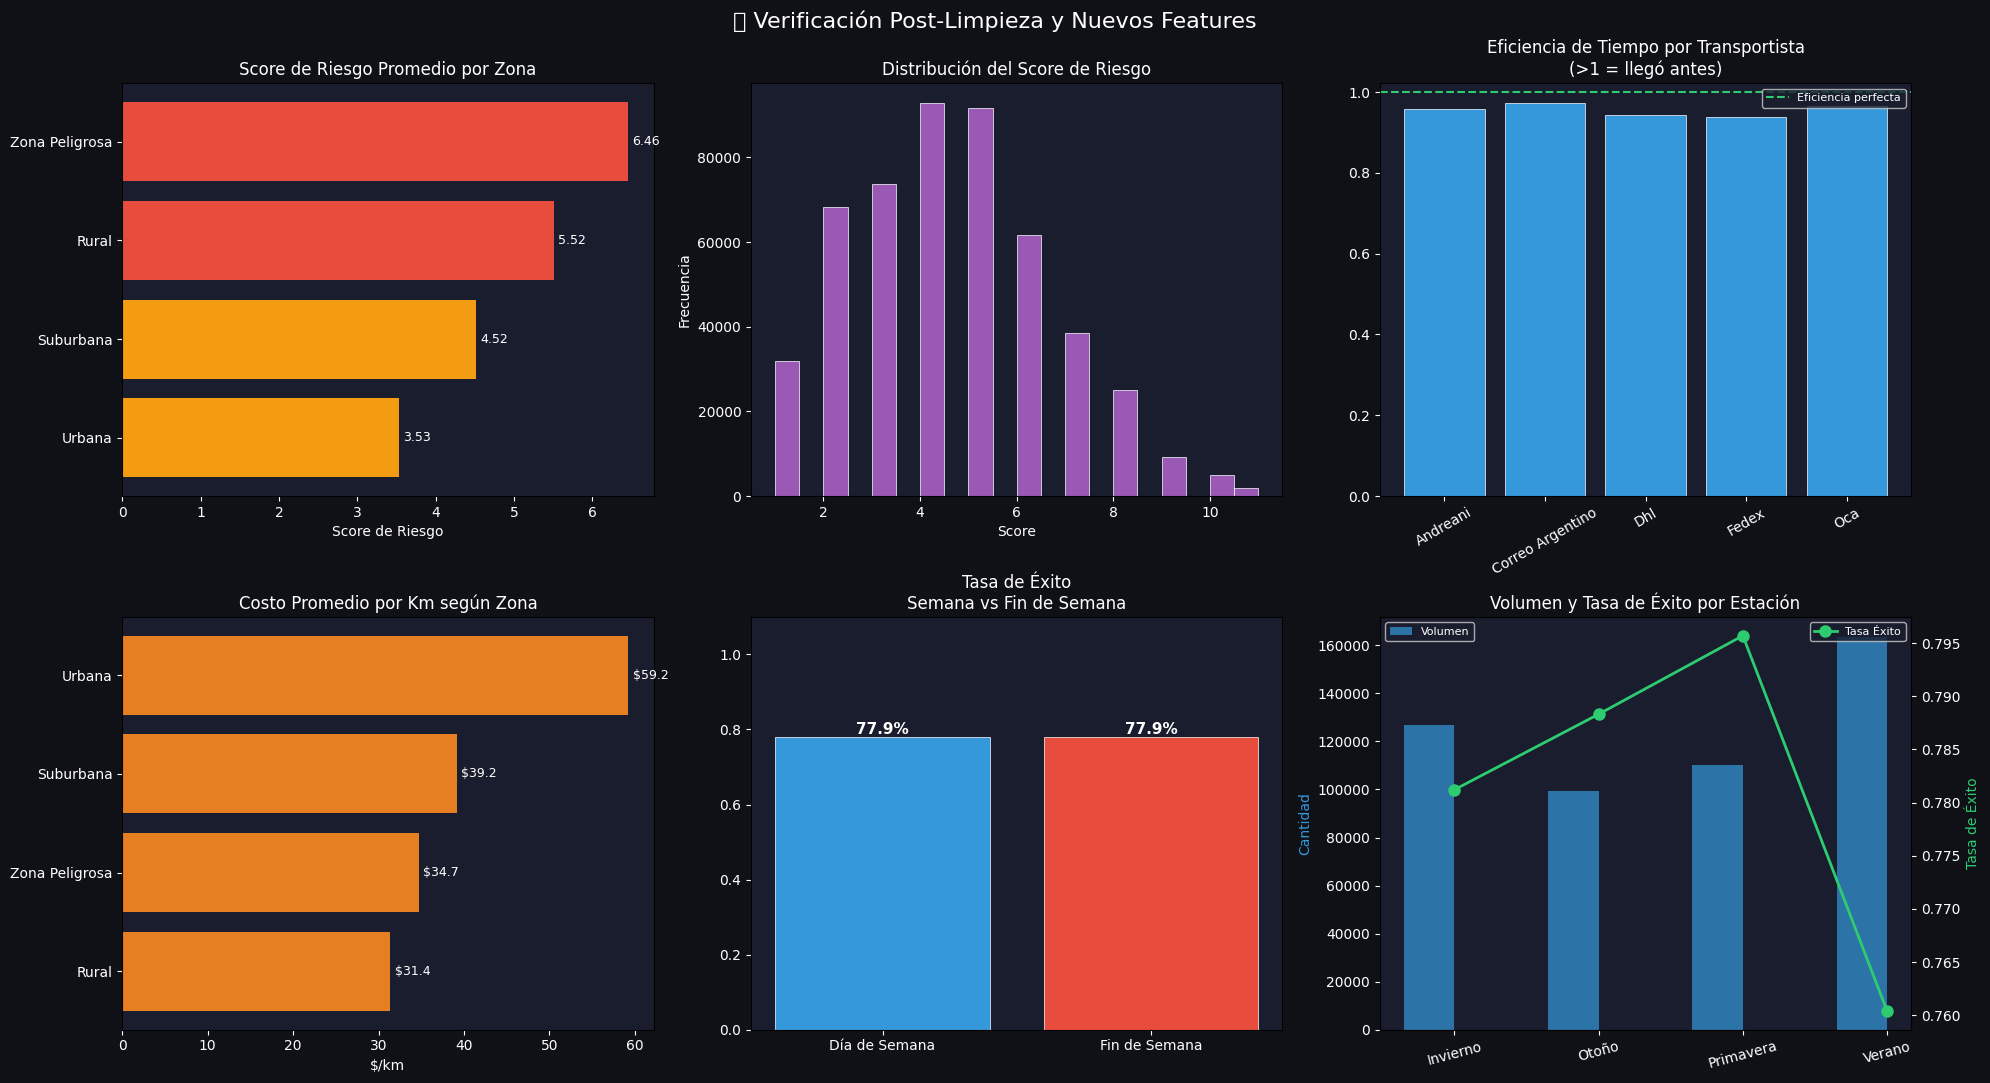

✅ Guardado: limpieza_02_nuevos_features.png


In [7]:
fig, axes = plt.subplots(2, 3, figsize=(20, 11))
fig.suptitle('✅ Verificación Post-Limpieza y Nuevos Features', fontsize=16)

# ── 1. Score de riesgo por zona ───────────────────────────
riesgo_zona_plot = df_limpio.groupby('zona')['score_riesgo'].mean().sort_values()
colores_r = ['#2ecc71' if r < 3 else '#f39c12'
             if r < 5 else '#e74c3c' for r in riesgo_zona_plot]
axes[0,0].barh(riesgo_zona_plot.index, riesgo_zona_plot.values, color=colores_r)
axes[0,0].set_title('Score de Riesgo Promedio por Zona')
axes[0,0].set_xlabel('Score de Riesgo')
for i, val in enumerate(riesgo_zona_plot.values):
    axes[0,0].text(val + 0.05, i, f'{val:.2f}', va='center', fontsize=9)

# ── 2. Distribución score de riesgo ──────────────────────
axes[0,1].hist(df_limpio['score_riesgo'], bins=20,
               color='#9b59b6', edgecolor='white', linewidth=0.5)
axes[0,1].set_title('Distribución del Score de Riesgo')
axes[0,1].set_xlabel('Score')
axes[0,1].set_ylabel('Frecuencia')

# ── 3. Eficiencia de tiempo por transportista ─────────────
efic_trans = df_limpio.groupby('transportista')['eficiencia_tiempo'].mean()
axes[0,2].bar(efic_trans.index, efic_trans.values,
              color='#3498db', edgecolor='white', linewidth=0.5)
axes[0,2].axhline(y=1.0, color='#2ecc71', linestyle='--',
                   label='Eficiencia perfecta')
axes[0,2].set_title('Eficiencia de Tiempo por Transportista\n(>1 = llegó antes)')
axes[0,2].tick_params(axis='x', rotation=30)
axes[0,2].legend(fontsize=8)

# ── 4. Costo por km por zona ──────────────────────────────
costo_km_zona = df_limpio.groupby('zona')['costo_por_km'].mean().sort_values()
axes[1,0].barh(costo_km_zona.index, costo_km_zona.values, color='#e67e22')
axes[1,0].set_title('Costo Promedio por Km según Zona')
axes[1,0].set_xlabel('$/km')
for i, val in enumerate(costo_km_zona.values):
    axes[1,0].text(val + 0.5, i, f'${val:.1f}', va='center', fontsize=9)

# ── 5. Entregas fin de semana vs semana ───────────────────
fds_stats = df_limpio.groupby('es_fin_semana')['entrega_exitosa'].mean()
labels    = ['Día de Semana', 'Fin de Semana']
colores_fds = ['#3498db', '#e74c3c']
bars = axes[1,1].bar(labels, fds_stats.values, color=colores_fds,
                      edgecolor='white', linewidth=0.5)
axes[1,1].set_title('Tasa de Éxito\nSemana vs Fin de Semana')
axes[1,1].set_ylim(0, 1.1)
for bar, val in zip(bars, fds_stats.values):
    axes[1,1].text(bar.get_x() + bar.get_width()/2,
                   val + 0.01, f'{val:.1%}',
                   ha='center', fontsize=11, fontweight='bold')

# ── 6. Distribución estaciones ────────────────────────────
estacion_stats = df_limpio.groupby('estacion').agg(
    total=('shipment_id', 'count'),
    tasa=('entrega_exitosa', 'mean')
)
x     = range(len(estacion_stats))
width = 0.35
ax6b  = axes[1,2].twinx()
axes[1,2].bar([i - width/2 for i in x], estacion_stats['total'],
               width, color='#3498db', alpha=0.7, label='Volumen')
ax6b.plot(x, estacion_stats['tasa'], 'o-',
          color='#2ecc71', linewidth=2, markersize=8, label='Tasa Éxito')
axes[1,2].set_xticks(x)
axes[1,2].set_xticklabels(estacion_stats.index, rotation=15)
axes[1,2].set_title('Volumen y Tasa de Éxito por Estación')
axes[1,2].set_ylabel('Cantidad', color='#3498db')
ax6b.set_ylabel('Tasa de Éxito', color='#2ecc71')
axes[1,2].legend(loc='upper left', fontsize=8)
ax6b.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "limpieza_02_nuevos_features.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: limpieza_02_nuevos_features.png")

In [8]:
print("=" * 60)
print("💾 GUARDANDO DATASET LIMPIO Y PROCESADO")
print("=" * 60)

# ── Seleccionar columnas finales para modelado ────────────
cols_finales = [
    # ID y fecha
    'shipment_id', 'fecha_envio',
    # Variables originales
    'provincia', 'latitud', 'longitud', 'distancia_km',
    'zona', 'tipo_cliente', 'transportista', 'chofer',
    'tiempo_estimado_horas', 'tiempo_real_horas',
    'estado', 'motivo_fallo', 'costo_envio', 'demora_horas',
    'entrega_exitosa', 'mes', 'anio', 'dia_semana',
    'clima', 'evento_especial', 'zona_peligrosa',
    # Features nuevos
    'diferencia_tiempo', 'llego_tarde', 'eficiencia_tiempo',
    'costo_por_km', 'velocidad_kmh', 'dia_del_anio',
    'semana_del_anio', 'es_fin_semana', 'es_quincena',
    'estacion', 'score_riesgo',
    # Encoded
    'estado_encoded', 'provincia_encoded', 'zona_encoded',
    'transportista_encoded', 'clima_encoded',
    'evento_especial_encoded', 'estacion_encoded',
]

# Filtrar solo las que existen
cols_finales = [c for c in cols_finales if c in df_encoded.columns]
df_final     = df_encoded[cols_finales].copy()

# Guardar
df_final.to_csv(DATA_PROCESSED, index=False)

size_mb = os.path.getsize(DATA_PROCESSED) / (1024 * 1024)
print(f"✅ Dataset limpio guardado:")
print(f"   Ruta     : {DATA_PROCESSED}")
print(f"   Tamaño   : {size_mb:.1f} MB")
print(f"   Filas    : {len(df_final):,}")
print(f"   Columnas : {len(df_final.columns)}")
print(f"\n📋 Columnas del dataset final:")
for col in df_final.columns:
    print(f"   → {col}")

💾 GUARDANDO DATASET LIMPIO Y PROCESADO
✅ Dataset limpio guardado:
   Ruta     : C:\Users\matup\OneDrive\Documentos\sistema_de_Predicción_de_Fallos_en_Última Milla\data\processed\dataset_limpio.csv
   Tamaño   : 144.3 MB
   Filas    : 500,000
   Columnas : 41

📋 Columnas del dataset final:
   → shipment_id
   → fecha_envio
   → provincia
   → latitud
   → longitud
   → distancia_km
   → zona
   → tipo_cliente
   → transportista
   → chofer
   → tiempo_estimado_horas
   → tiempo_real_horas
   → estado
   → motivo_fallo
   → costo_envio
   → demora_horas
   → entrega_exitosa
   → mes
   → anio
   → dia_semana
   → clima
   → evento_especial
   → zona_peligrosa
   → diferencia_tiempo
   → llego_tarde
   → eficiencia_tiempo
   → costo_por_km
   → velocidad_kmh
   → dia_del_anio
   → semana_del_anio
   → es_fin_semana
   → es_quincena
   → estacion
   → score_riesgo
   → estado_encoded
   → provincia_encoded
   → zona_encoded
   → transportista_encoded
   → clima_encoded
   → evento_especial

In [9]:
print("\n" + "=" * 60)
print("✅ LIMPIEZA Y TRANSFORMACIÓN COMPLETADA")
print("=" * 60)

print(f"""
📊 COMPARACIÓN ANTES vs DESPUÉS:
   Filas originales   : {len(df_original):,}
   Filas procesadas   : {len(df_final):,}
   Columnas originales: {len(df_original.columns)}
   Columnas finales   : {len(df_final.columns)}
   Features nuevos    : {len(df_final.columns) - len(df_original.columns)}
   Nulos restantes    : {df_final.isnull().sum().sum():,}

📁 ARCHIVOS GENERADOS:
   → data/processed/dataset_limpio.csv
   → outputnts/models/encoders.pkl
   → outputnts/models/cols_escalar.pkl
   → outputnts/figures/limpieza_01_nulos.png
   → outputnts/figures/limpieza_02_nuevos_features.png

🚀 PRÓXIMO PASO:
   03_feature_engineering_y_modelado.ipynb
""")


✅ LIMPIEZA Y TRANSFORMACIÓN COMPLETADA

📊 COMPARACIÓN ANTES vs DESPUÉS:
   Filas originales   : 500,000
   Filas procesadas   : 500,000
   Columnas originales: 23
   Columnas finales   : 41
   Features nuevos    : 18
   Nulos restantes    : 0

📁 ARCHIVOS GENERADOS:
   → data/processed/dataset_limpio.csv
   → outputnts/models/encoders.pkl
   → outputnts/models/cols_escalar.pkl
   → outputnts/figures/limpieza_01_nulos.png
   → outputnts/figures/limpieza_02_nuevos_features.png

🚀 PRÓXIMO PASO:
   03_feature_engineering_y_modelado.ipynb



In [2]:
import os

# ── Proyecto 1 ────────────────────────────────────────────
notebook_path = os.path.join(
    r"C:\Users\matup\OneDrive\Documentos",
    "analisis_performance_comercial",
    "Entrega_final_Villagra_Jorge_Matias.ipynb"
)

with open(notebook_path, 'r', encoding='utf-8') as f:
    contenido = f.read()

# Reemplazar ruta personal por ruta genérica
contenido = contenido.replace(
    r"C:\\Users\\matup\\OneDrive\\Documentos\\analisis_performance_comercial",
    "."
)
contenido = contenido.replace(
    r"C:\Users\matup\OneDrive\Documentos\analisis_performance_comercial",
    "."
)

with open(notebook_path, 'w', encoding='utf-8') as f:
    f.write(contenido)

print("✅ Rutas personales limpiadas en notebook")

# ── Crear .gitignore para ambos proyectos ─────────────────
gitignore = """# Python
__pycache__/
*.py[cod]
*.pyo
.env

# Jupyter
.ipynb_checkpoints/

# Datos — NO subir CSV con datos reales
dataset/raw/*.csv
dataset/processed/*.csv
data/raw/*.csv
data/processed/*.csv

# Modelos entrenados pesados
outputnts/models/*.pkl

# Sistema operativo
.DS_Store
Thumbs.db

# VSCode
.vscode/
"""

# Guardar .gitignore en ambos proyectos
proyectos = [
    r"C:\Users\matup\OneDrive\Documentos\analisis_performance_comercial",
    os.path.join(r"C:\Users\matup\OneDrive\Documentos",
                 "sistema_de_Predicción_de_Fallos_en_Última Milla")
]

for proyecto in proyectos:
    path = os.path.join(proyecto, ".gitignore")
    with open(path, 'w', encoding='utf-8') as f:
        f.write(gitignore)
    print(f"✅ .gitignore creado en: {os.path.basename(proyecto)}")

print("""
🛡️ RESUMEN DE SEGURIDAD:
   ✅ Rutas personales limpiadas
   ✅ CSV excluidos del repositorio
   ✅ Modelos .pkl excluidos
   ✅ Carpetas de sistema excluidas

⚠️  Los CSV NO se subirán a GitHub
    Si alguien clona tu repo necesita
    sus propios datos para ejecutarlo.
""")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\matup\\OneDrive\\Documentos\\analisis_performance_comercial\\Entrega_final_Villagra_Jorge_Matias.ipynb'